# Imports

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


# Reproducibilitty

In [4]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Utils

In [5]:
def plot_loss_curve(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Erro de Treino')
    plt.plot(history.history['val_loss'], label='Erro de Validação')
    plt.title('Curva de Erro (Loss) do Autoencoder')
    plt.xlabel('Época')
    plt.ylabel('Erro Médio Quadrático (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_reconstructions(model, data, n=10):
    reconstructed_imgs = model.predict(data)
    
    if data.shape[1] == 784:
        data = data.reshape(-1, 28, 28)
        reconstructed_imgs = reconstructed_imgs.reshape(-1, 28, 28)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Imagens Originais')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Imagens Reconstruídas')
    plt.show()

# Data Preparation

In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
x_train, x_val = train_test_split(
    x_train, test_size=0.2, random_state=42
)

x_train_conv = np.expand_dims(x_train.astype('float32') / 255., axis=-1)
x_test_conv = np.expand_dims(x_test.astype('float32') / 255., axis=-1)
x_val_conv = np.expand_dims(x_val.astype('float32') / 255., axis=-1)

In [7]:
print(f"Formato dos dados de treino para CNN: {x_train_conv.shape}")
print(f"Formato dos dados de validação para CNN: {x_val_conv.shape}")
print(f"Formato dos dados de teste para CNN: {x_test_conv.shape}")

Formato dos dados de treino para CNN: (48000, 28, 28, 1)
Formato dos dados de validação para CNN: (12000, 28, 28, 1)
Formato dos dados de teste para CNN: (10000, 28, 28, 1)


In [8]:
x_train_flat = (x_train.astype('float32') / 255.).reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = (x_test.astype('float32') / 255.).reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val_flat = (x_val.astype('float32') / 255.).reshape((len(x_val), np.prod(x_val.shape[1:])))

In [9]:
print(f"Formato dos dados de treino para DNN: {x_train_flat.shape}")
print(f"Formato dos dados de validação para DNN: {x_val_flat.shape}")
print(f"Formato dos dados de teste para DNN: {x_test_flat.shape}")

Formato dos dados de treino para DNN: (48000, 784)
Formato dos dados de validação para DNN: (12000, 784)
Formato dos dados de teste para DNN: (10000, 784)


# Autoenconder Fully Conected

## Model

In [10]:
input_dim = x_train_flat.shape[1]  # 28*28 = 784
latent_dim = 16

input_layer = Input(shape=(input_dim,), name='encoder_input')

# Codificador (Encoder)
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(latent_dim, activation='relu', name='latent_space')(encoder)

# Decodificador (Decoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid', name='decoder_output')(decoder)

autoencoder_dense = Model(inputs=input_layer, outputs=decoder, name='autoencoder_dense')
autoencoder_dense.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_dense.summary()

I0000 00:00:1756762540.476240  173253 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "autoencoder_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,456 (872.88 KB)

 Trainable params: 223,456 (872.88 KB)

 Non-trainable params: 0 (0.00 B)

## Train

In [11]:
history_dense = autoencoder_dense.fit(
    x_train_flat, 
    x_train_flat, 
    epochs=30,
    batch_size=256,
    shuffle=True,
    validation_data=(x_val_flat, x_val_flat)
)

Epoch 1/30


I0000 00:00:1756762545.142729  173577 service.cc:152] XLA service 0x7fa9e8010310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756762545.143061  173577 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-09-01 18:35:45.235744: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756762545.795288  173577 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-01 18:35:46.820552: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 8 bytes spill stores, 8 bytes spill loads

2025-09-01 18:35:47.304254: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

 30/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6560

I0000 00:00:1756762556.411877  173577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5117

2025-09-01 18:35:58.276467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 8 bytes spill stores, 8 bytes spill loads

2025-09-01 18:35:58.715097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 18:35:59.203174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 112 bytes spill stores, 112 bytes spill loads

2025-09-01 18:35:59.403795: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_320', 4 bytes spill stores, 4 bytes spill loads

2025-09-01 18:36:00.484199: I external/local_x

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5093

2025-09-01 18:36:10.717529: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 18:36:10.939797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 132 bytes spill stores, 132 bytes spill loads

2025-09-01 18:36:10.939910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 164 bytes spill stores, 168 bytes spill loads

2025-09-01 18:36:12.338212: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_74', 124 bytes spill stores, 124 bytes spill loads

2025-09-01 18:36:13.071950: I external/loc

188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - loss: 0.4206 - val_loss: 0.3434
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3279 - val_loss: 0.3184
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3137 - val_loss: 0.3113
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3097 - val_loss: 0.3086
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3066 - val_loss: 0.3054
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3032 - val_loss: 0.3023
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3005 - val_loss: 0.2997
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ -1s -7323us/step - loss: 0.2985 - val_loss: 0.2979
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2971 - val_loss: 0.2966
Epoch 10/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2960 - val_loss: 0.2956
Epoch 11/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2949 - val_loss: 0.2945
Epoch 12/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

## Results


Resultados para o Autoencoder Convolucional:


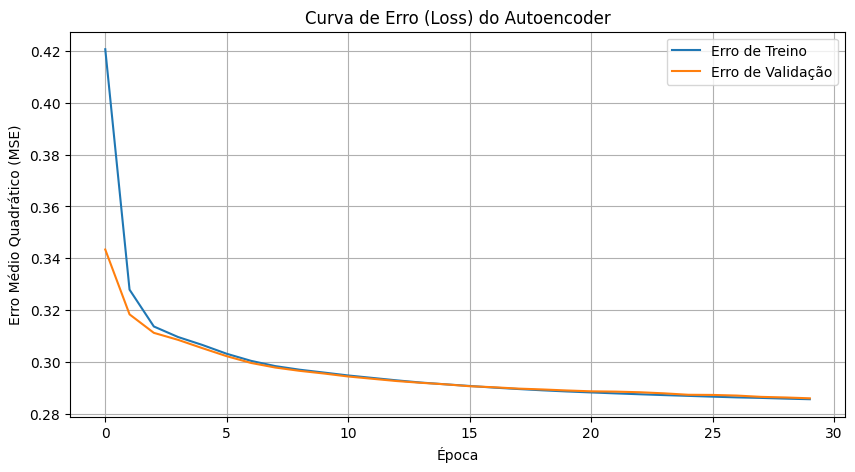

2025-09-01 18:36:46.067436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 18:36:46.096888: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 4 bytes spill stores, 4 bytes spill loads



311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-09-01 18:36:48.913446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_61', 8 bytes spill stores, 8 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


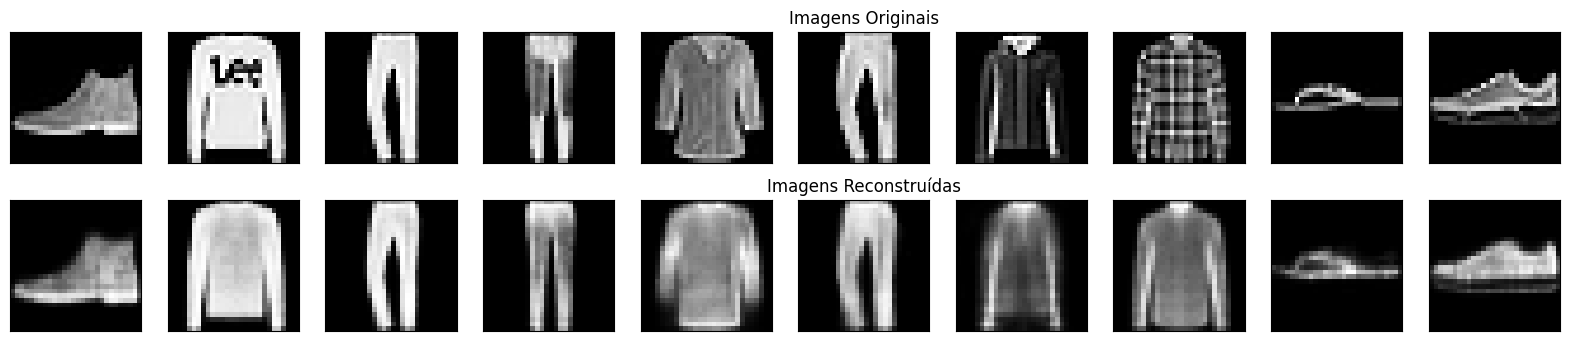

In [12]:
print("\nResultados para o Autoencoder Convolucional:")
plot_loss_curve(history_dense)
plot_reconstructions(autoencoder_dense, x_test_flat, n=10)

# Autoencoder Convolucional

## Model

In [13]:
input_layer = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x) # 14x14x16
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # 7x7x8 (espaço latente)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # 14x14x8
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 28x28x16
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # 28x28x1

autoencoder_conv = Model(input_layer, decoded)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy') 

autoencoder_conv.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217 (12.57 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

## Train

In [14]:
history_conv = autoencoder_conv.fit(
    x_train_conv,
    x_train_conv,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val_conv, x_val_conv)
)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.3347 - val_loss: 0.2849
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2809 - val_loss: 0.2784
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2764 - val_loss: 0.2749
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2735 - val_loss: 0.2727
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2717 - val_loss: 0.2711
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2703 - val_loss: 0.2699
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2693 - val_loss: 0.2690
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2684 - val_loss: 0.2682
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.2676 - val_loss: 0.2675
Epoch 10/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2669 - val_loss: 0.2668
Epoch 11/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2663 - val_loss: 0.2662
Epoch 12/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/

## Results


Resultados para o Autoencoder Convolucional:


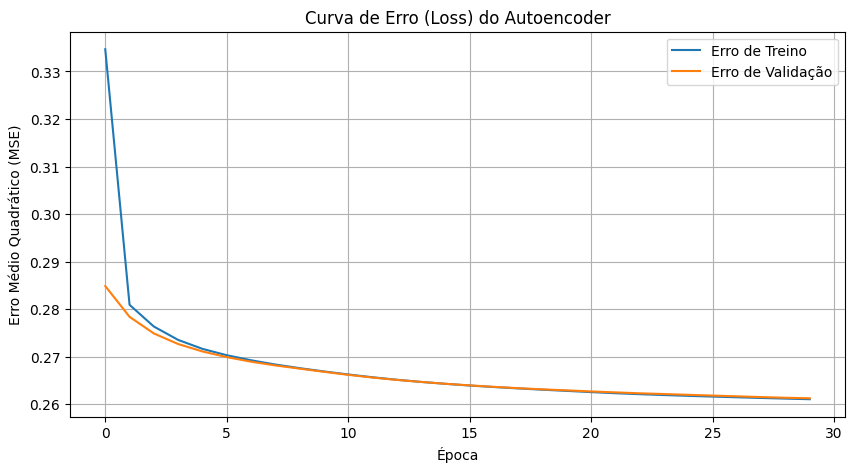

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


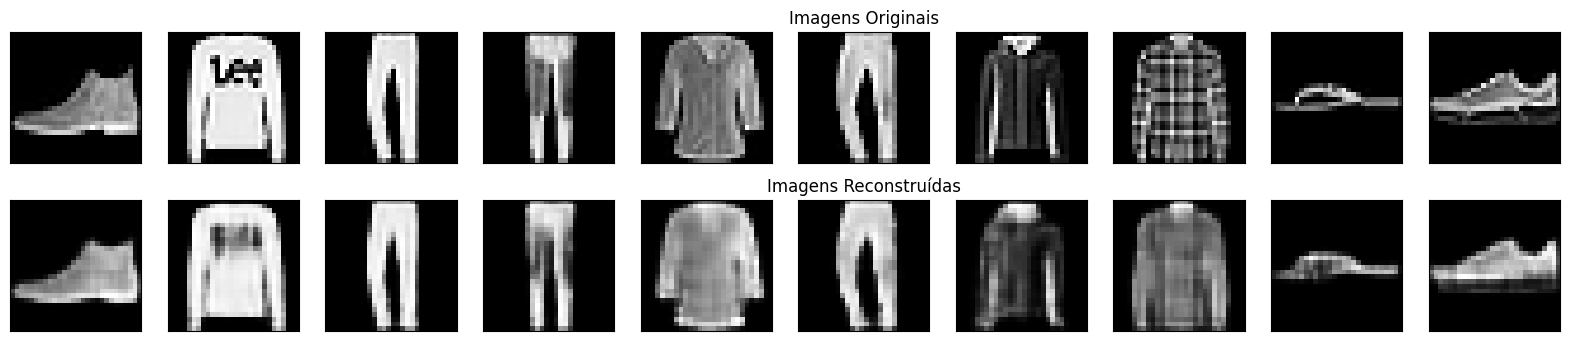

In [15]:
print("\nResultados para o Autoencoder Convolucional:")
plot_loss_curve(history_conv)
plot_reconstructions(autoencoder_conv, x_test_conv, n=10)

# 4.b) Denoising Autoencoder

In [64]:
def noise(inputs, noise_factor=0.4):
    noisy_array = inputs + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=inputs.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    n = 10
    images1 = array1[:n, :]
    images2 = array2[:n, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

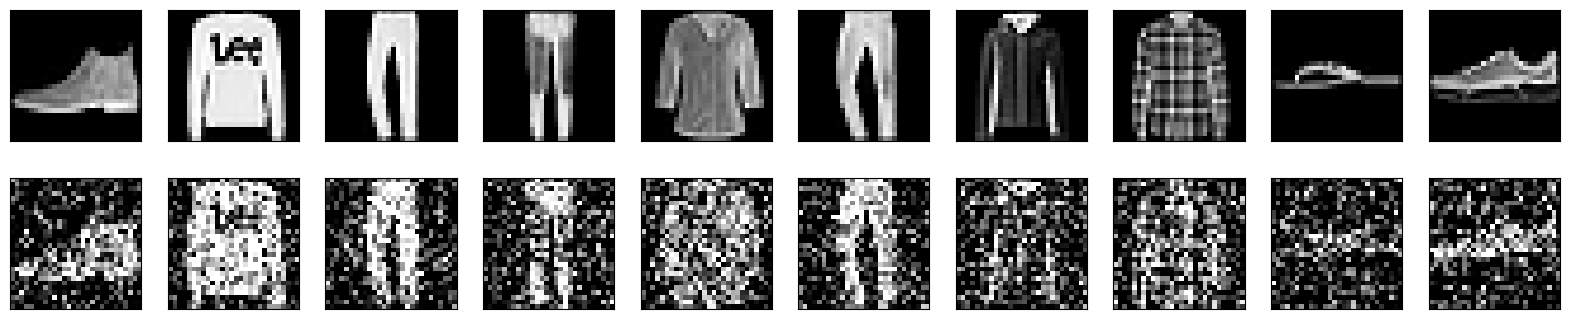

In [65]:
display(x_test_conv, noise(x_test_conv))

In [66]:
input_layer = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # 14x14x16
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # 7x7x8 (espaço latente)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # 14x14x8
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 28x28x16
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # 28x28x1

autoencoder_denoise = Model(input_layer, decoded)
autoencoder_denoise.compile(optimizer='adam', loss='binary_crossentropy') 

autoencoder_denoise.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,785 (49.94 KB)

 Trainable params: 12,785 (49.94 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
noisy_train = noise(x_train_conv)
noisy_val = noise(x_val_conv)
history_denoiser = autoencoder_denoise.fit(
    noisy_train,
    x_train_conv,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_val, x_val_conv)
)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.3485 - val_loss: 0.3033
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.3000 - val_loss: 0.2978
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2963 - val_loss: 0.2953
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2942 - val_loss: 0.2934
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2926 - val_loss: 0.2922
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2914 - val_loss: 0.2912
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2904 - val_loss: 0.2903
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2896 - val_loss: 0.2897
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2891 - val_loss: 0.2893
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2885 - val_loss: 0.2888
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2881 - val_loss: 0.2883
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s


Resultados para o Autoencoder Denoiser:


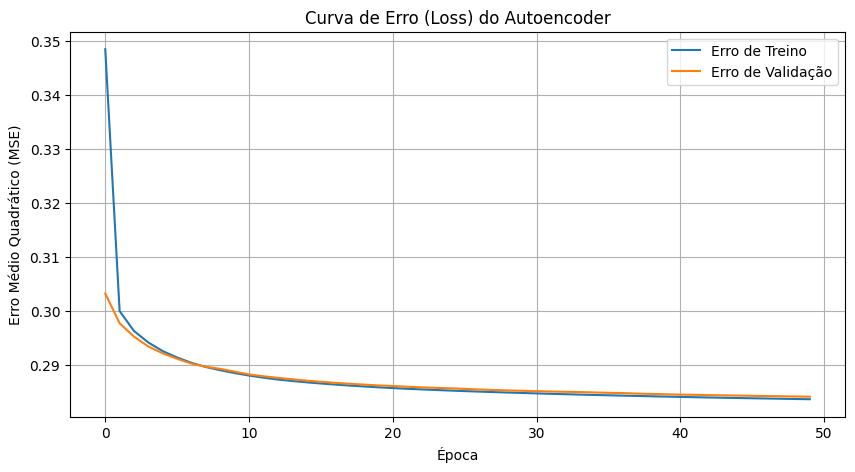

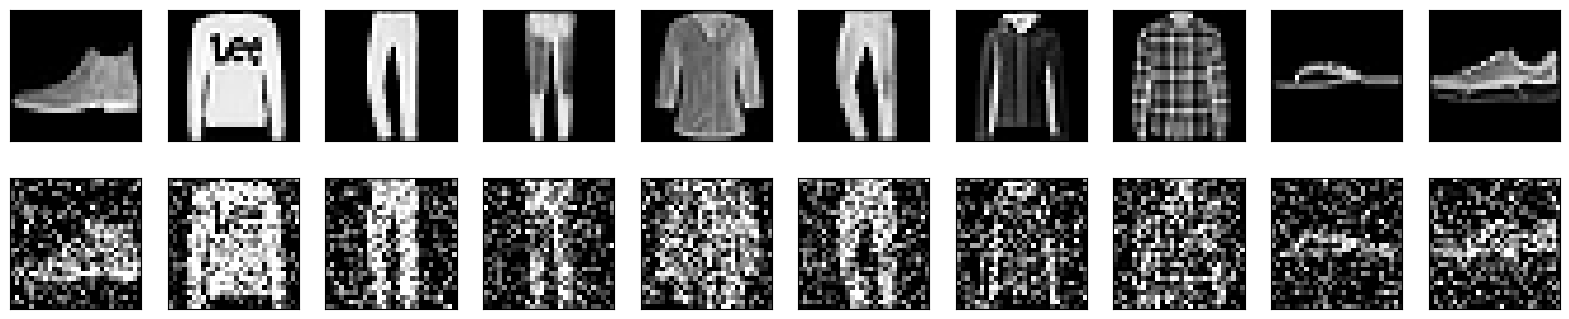

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


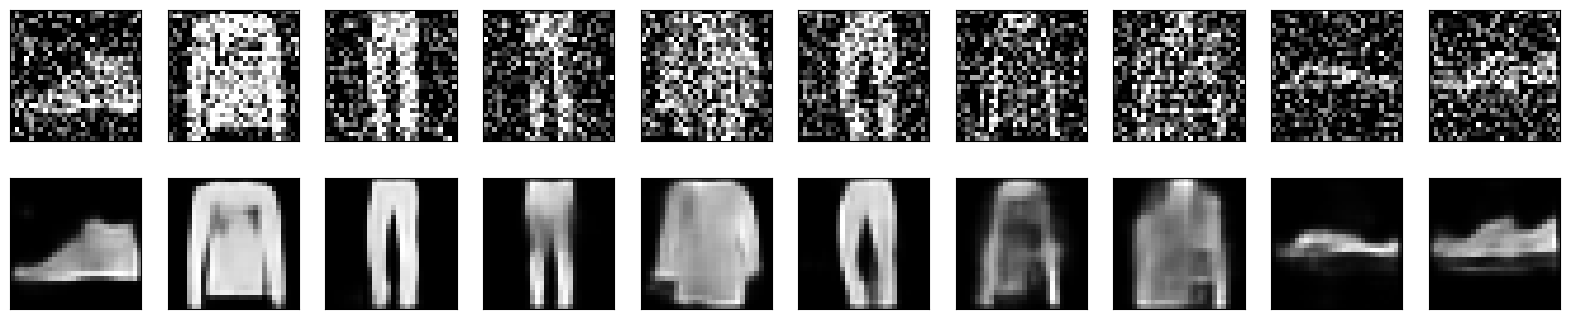

In [68]:
print("\nResultados para o Autoencoder Denoiser:")
plot_loss_curve(history_denoiser)
noisy_test = noise(x_test_conv)
display(x_test_conv, noisy_test)
display(noisy_test, autoencoder_denoise.predict(noisy_test))

In [69]:
noisy_train = noise(x_train_conv, noise_factor=0.2)
noisy_val = noise(x_val_conv, noise_factor=0.2)
history_denoiser = autoencoder_denoise.fit(
    noisy_train,
    x_train_conv,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_val, x_val_conv)
)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2695 - val_loss: 0.2691
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2684 - val_loss: 0.2685
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2681 - val_loss: 0.2682
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2678 - val_loss: 0.2680
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2676 - val_loss: 0.2679
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2674 - val_loss: 0.2677
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2673 - val_loss: 0.2676
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2672 - val_loss: 0.2674
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2670 - val_loss: 0.2673
Epoch 10/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2669 - val_loss: 0.2672
Epoch 11/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2668 - val_loss: 0.2671
Epoch 12/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5


Resultados para o Autoencoder Denoiser:


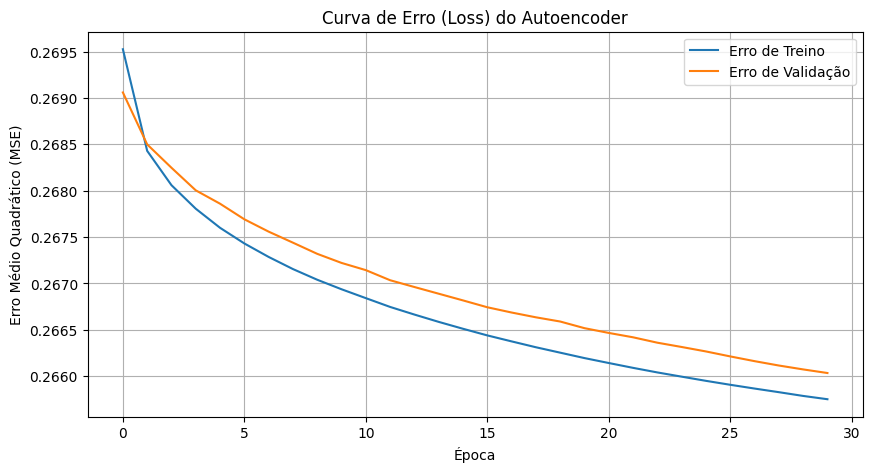

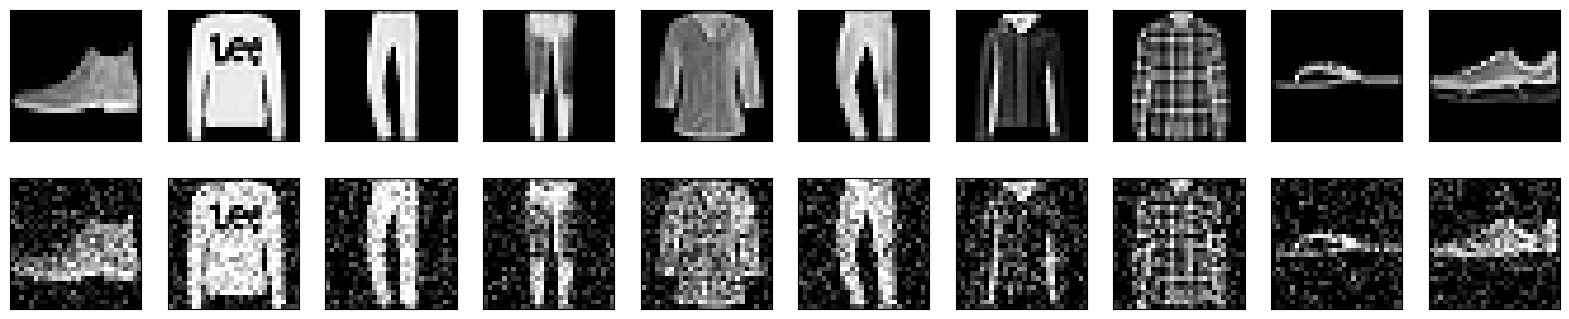

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


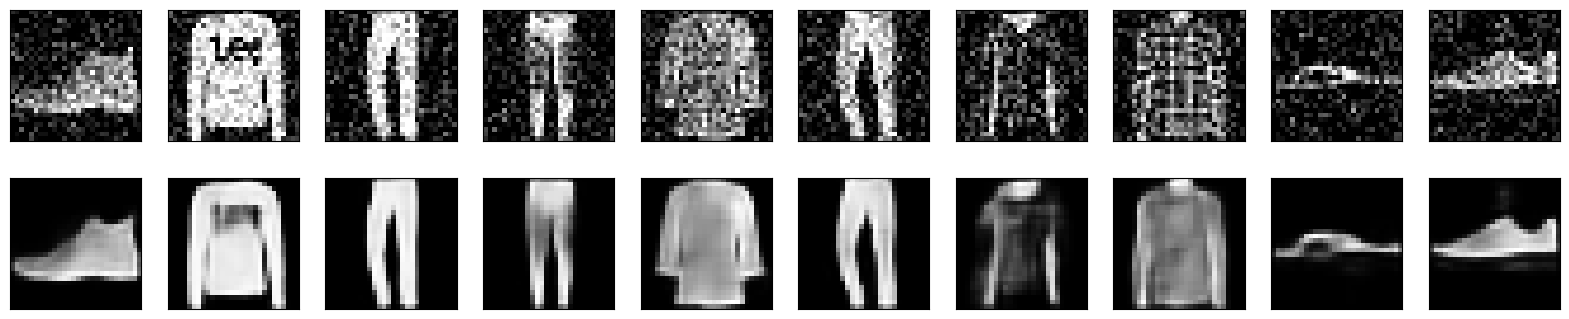

In [70]:
print("\nResultados para o Autoencoder Denoiser:")
plot_loss_curve(history_denoiser)
noisy_test = noise(x_test_conv, noise_factor=0.2)
display(x_test_conv, noisy_test)
display(noisy_test, autoencoder_denoise.predict(noisy_test))